<a href="https://colab.research.google.com/github/acoiman/predict_builtup_nn/blob/main/predicting_builtup_areas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Predicting Built-up Areas Using Satellite Images and Neural Networks (NN)**

###<center><strong>Abraham Coiman</strong></center>

Through this notebook, we will predict built-up areas as a proxy of urban growth using satellite images and Neural Networks. Our study area encompasses two intermediate cities ([Acarigua](https://en.wikipedia.org/wiki/Acarigua) and [Cagua](https://en.wikipedia.org/wiki/Cagua)) in [Venezuela](https://en.wikipedia.org/wiki/Venezuela). The prediccion will be carried out in 2018.

To get the target variable, we will process and download an image provided by Tsinghua University (China), containing information on annual change of global
impervious surface, click [here](https://developers.google.com/earth-engine/datasets/catalog/Tsinghua_FROM-GLC_GAIA_v10) to obtain more information. To get the predictor variables, we will process and download two Landsat 8 Surface Reflectance images provided by the [USGS](https://developers.google.com/earth-engine/datasets/catalog/LANDSAT_LC08_C01_T2_SR). Since our study area encompasses two intermediate cities in Venezuela (Acarigua and Cagua), we will process and download an image for each city. One image will be used to train the NN Model (Acarigua city) and the other image will be used for prediction (Cagua city). 

The images will be converted into NumPy matrices according to the
requirements of the NN model. A Neural Network model will be configured using [Keras](https://keras.io/). The sequential class and the relu activation function will be used. Once trained the model, we will use it to predict built-up areas on the prediction image (Cagua city). The prediction output image will be plotted with the Matplotlib library.

## 1. Module Installations

In [1]:
# mount Google Drive
from google.colab import drive # import drive from google colab

# default location for the drive
ROOT = "/content/drive" 
print(ROOT) # print content of ROOT (optional)

drive.mount(ROOT) # we mount the google drive at /content/drive

/content/drive
Mounted at /content/drive


In [10]:
# change this path accoding to your Google Drive diectory
%cd 'drive/My Drive/Colab_Notebooks/predict_builtup_NN'

/content/drive/My Drive/Colab_Notebooks/predict_builtup_NN


Now, we are going to install and import all the necessary libraries.



In [2]:
# install modules
!pip install rasterio --quiet
!pip install geopandas --quiet
!pip install geemap --quiet

     |████████████████████████████████| 19.3 MB 22.7 MB/s 
     |████████████████████████████████| 994 kB 5.3 MB/s 
     |████████████████████████████████| 15.4 MB 38 kB/s 
     |████████████████████████████████| 6.6 MB 46.5 MB/s 
     |████████████████████████████████| 476 kB 5.1 MB/s 
     |████████████████████████████████| 1.2 MB 33.5 MB/s 
     |████████████████████████████████| 76 kB 5.3 MB/s 
     |████████████████████████████████| 130 kB 44.5 MB/s 
     |████████████████████████████████| 98 kB 7.7 MB/s 
     |████████████████████████████████| 76 kB 4.6 MB/s 
     |████████████████████████████████| 1.3 MB 32.8 MB/s 
     |████████████████████████████████| 3.3 MB 24.6 MB/s 
     |████████████████████████████████| 94 kB 3.3 MB/s 
     |████████████████████████████████| 219 kB 39.7 MB/s 
     |████████████████████████████████| 1.6 MB 33.6 MB/s 
     |████████████████████████████████| 115 kB 48.3 MB/s 
     |████████████████████████████████| 551 kB 42.6 MB/s 
     |██████████████████

In [6]:
# common modules
import matplotlib.pyplot as plt
import os
import numpy as np
from time import  time

# geospatial modules
from osgeo import gdal
import rasterio
from shapely.geometry import Polygon
import geopandas as gpd

# machine learning modules
from keras.models import Sequential, Model
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Conv1D, Conv2D, MaxPool1D, MaxPooling1D, Flatten
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

from keras import backend
backend.set_image_data_format('channels_last')

# GEE modules
import geemap
import ee

# avoid warning messages
import warnings
warnings.filterwarnings('ignore')

The cells below will allow us to authenticate and initialize Google Earth Engine (GEE) services.

In [ ]:
!earthengine authenticate

Instructions for updating:
non-resource variables are not supported in the long term
To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=tBUFAlkYrS3TvFO1kalpu0wGDepB47W80GgDHQ-P4nQ&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWjoiLlxvZLJWzlYNG97rPpp7lcjGSH9L3PJXQ_TPCAIfVDOhd5wni8

Successfully saved authorization token.


In [ ]:
# initialize GEE
ee.Initialize()

## 2. Downloading data from GEE

### 2.1. Downloading Tsinghua dataset  on annual change of global impervious surface

We will proceed to call the Tsinghua dataset and convert it to a binary image.

In [ ]:
dataset = ee.Image("Tsinghua/FROM-GLC/GAIA/v10")
binary_gaia = dataset.expression(
    "(b('change_year_index') > 1) ? 1" +
      ": (b('change_year_index') < 34) ? 1" +
          ": 0"
)

Next, we will create two ROIs (Region of Interest) to clip the impervious surface dataset and Landsat 8 imagery.

In [ ]:
# Acarigua city
roi_ac = ee.Geometry.Polygon(
    [[[-69.26051866953458, 9.61805089389198],
          [-69.26051866953458, 9.505651342895433],
          [-69.15065538828458, 9.505651342895433],
          [-69.15065538828458, 9.61805089389198]]])

# Cagua City
roi_ca = ee.Geometry.Polygon(
    [[[-67.49243683992786, 10.21122393229713],
          [-67.49243683992786, 10.146512419354995],
          [-67.43338532625599, 10.146512419354995],
          [-67.43338532625599, 10.21122393229713]]])

Now, we will clip our impervious surface dataset and export it to our Google Drive.



In [ ]:
clipped_gaia_ac = binary_gaia.clip(roi_ac).float()

In [ ]:
geemap.ee_export_image(clipped_gaia_ac, filename="l8_acarigua2018_builtup.tif", scale=30, file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/Colab_Notebooks/predict_builtup_NN/l8_acarigua2018_builtup.tif


### 2.2. Downloading Landsat 8 Surface Reflectance (SR)

We will create a function to set 0 value to water masks based on the pixel_qa band of Landsat 8 SR data.



In [ ]:
def maskL8sr(image): 
    '''function to set 0 value to water masks based on the pixel_qa band of Landsat 8 SR data
    --------------------
    param: (ee.Image) image Input Landsat 8 SR image
    return (ee.Image) Watermasked Landsat 8 image with values of 0
    '''
    # bits 2 is water
    waterBitMask = (1 << 2)
    
    #get the pixel QA band.
    qa = image.select('pixel_qa')
    
    # flag should be set to zero, indicating non-water conditions
    mask = qa.bitwiseAnd(waterBitMask).eq(0)
    
    # return mask and set value to 0
    return image.updateMask(mask).unmask(0);

Let's get the two Landsat 8 surface reflectance image, and filter by ROI, date,  and cloud cover.

In [ ]:
# import the Landsat 8 surface reflectance image collection
l8 = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR');

# get the least cloudy image in Acarigua in 2018
image_ac = ee.Image(
    l8.filterBounds(roi_ac)
    .filterDate('2018-01-01', '2018-12-31')
    .sort('CLOUD_COVER')
    .first()
    )

# get the least cloudy image in Valle de la Pascua in 2018
image_ca = ee.Image(
    l8.filterBounds(roi_ca)
    .filterDate('2018-01-01', '2018-12-31')
    .map(maskL8sr) # mask water
    .sort('CLOUD_COVER')
    .first()
    )

Now, we will clip our Landsat 8 image (Acarigua), reproject, and export to our Google Drive.

In [ ]:
image_ac_clip = image_ac.select(['B5', 'B4', 'B2']).clip(roi_ac).float() # B5: NIR, B4: RED, B2: BLUE
proj = ee.Projection('EPSG:4326')
image_ac_clip_reproj = image_ac_clip.reproject(proj, None, 30)
geemap.ee_export_image(image_ac_clip_reproj, filename="l8_acarigua2018.tif", \
                       scale=30,file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/Colab_Notebooks/predict_builtup_NN/l8_acarigua2018.tif


Now, we will clip our Landsat 8 image (Cagua), reproject, and export to our Google Drive.



In [ ]:
image_ca_clip = image_ca.select(['B5', 'B4', 'B2']).clip(roi_ca).float()
image_ca_clip_reproj = image_ca_clip.reproject(proj, None, 30)
geemap.ee_export_image(image_ca_clip_reproj, filename="l8_cagua2018.tif",\
                       scale=30,  file_per_band=False)

Generating URL ...
Please wait ...
Data downloaded to /content/drive/My Drive/Colab_Notebooks/predict_builtup_NN/l8_cagua2018.tif


The following lines of code will help us to match the dimensions of the training images.

In [ ]:
# create polygon from coordinates to crop training images 
coordinates = [(-69.25880205576505, 9.615681407851428), (-69.25880205576505, 9.509037413120978),\
              (-69.15237200205411, 9.509037413120978), (-69.15237200205411, 9.615681407851428)]

def create_polygon(coords, polygon_name):
    '''Create a polygon from coordinates'''
    polygon = Polygon(coordinates)
    gdf = gpd.GeoDataFrame(crs = {'init':'epsg:4326'})
    gdf.loc[0,'name'] = polygon_name
    gdf.loc[0, 'geometry'] = polygon
    return gdf

# create a polygon by applying the above function
roi_ac_reduced = create_polygon(coordinates, "roi_ac_reduced")

# export polygon to shapefile 
roi_ac_reduced.to_file("roi_ac_reduced.shp")

# use the exported sapefile to crop both training images
!gdalwarp -of GTiff -overwrite -cutline "roi_ac_reduced.shp"  -crop_to_cutline "l8_acarigua2018.tif" "l8_acarigua2018_cropped.tif"
!gdalwarp -of GTiff -overwrite -cutline "roi_ac_reduced.shp"  -crop_to_cutline "l8_acarigua2018_builtup.tif" "l8_acarigua2018_builtup_cropped.tif"

Creating output file that is 395P x 396L.
Processing input file l8_acarigua2018.tif.
Using internal nodata values (e.g. -inf) for image l8_acarigua2018.tif.
Copying nodata values from source l8_acarigua2018.tif to destination l8_acarigua2018_cropped.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 395P x 396L.
Processing input file l8_acarigua2018_builtup.tif.
Using internal nodata values (e.g. -inf) for image l8_acarigua2018_builtup.tif.
Copying nodata values from source l8_acarigua2018_builtup.tif to destination l8_acarigua2018_builtup_cropped.tif.
0...10...20...30...40...50...60...70...80...90...100 - done.


## 3. Data Processing

We will proceed to load the corresponding images.

In [11]:
mxAcarigua = 'l8_acarigua2018_cropped.tif'
builtupAcarigua= 'l8_acarigua2018_builtup_cropped.tif'
mxCagua= 'l8_cagua2018.tif'

### 3.1. Acarigua data (training)

Next, we will open the Acarigua image with the [GDAL](https://gdal.org/) library, create an array, and group to create a Color Infrared (CIR) Composite composite.

In [12]:
mB_image = gdal.Open(mxAcarigua) 
mB_image = mB_image.ReadAsArray() 
mB_image = np.divide(mB_image, 100) # divide by 100 to convert data range from 0-10000 to 0-1000
mB_imageRGB = np.dstack((mB_image[2],mB_image[1],mB_image[0]))

# change data type
mB_imageRGB = mB_imageRGB.astype('uint8')
print('The dimension of the Acarigua false color array is: ',mB_imageRGB.shape)

The dimension of the Acarigua false color array is:  (396, 395, 3)


Next we will visualize the Acarigua image as a CIR composite. With this combination, vegetation appears in shades of red, urban areas are cyan blue, and soils vary from dark brown to light brown [1].

In [13]:
def cum_count(image):
    '''Function to improve constract using a percentage cumulative count used by QGIS
    '''
    min_percent = 2   # Low percentile
    max_percent = 98  # High percentile
    
    # find lower and upper percentile using percentile function
    lo, hi = np.percentile(image, (min_percent, max_percent))
    
    # apply linear "stretch" - lo goes to 0, and hi goes to 1
    res_img = (image.astype(float) - lo) / (hi-lo)
    
    # Multiply by 255, clamp range to [0, 255] and convert to uint8
    res_img = np.maximum(np.minimum(res_img*255, 255), 0).astype(np.uint8)
    
    return res_img

In [14]:
def vis_image(image, title):
    '''Function to visualize CIR composite'''
    with rasterio.open(image, 'r') as f:
        red, green, blue = f.read(1), f.read(2), f.read(3)
    # red
    redmej = cum_count(red) # improve image
     # green
    greenmej = cum_count(green) # improve imagen
    # blue
    bluemej = cum_count(blue) # improve imagen
    # stack bands
    rgbmej = np.dstack((redmej, greenmej, bluemej))
    
    # plot with marplotlib
    plt.figure(figsize=(8,13))
    plt.imshow(rgbmej)
    plt.axis('off')
    plt.title(title)

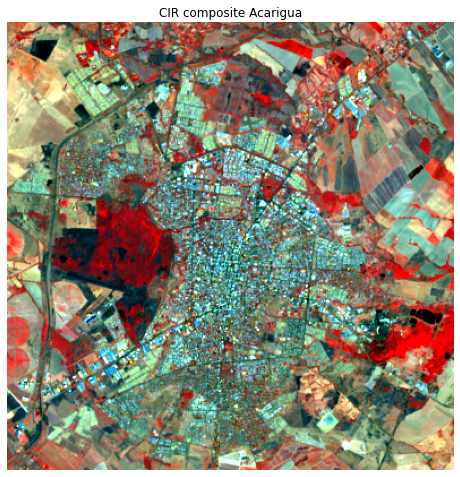

In [ ]:
vis_image(mxAcarigua, 'CIR composite Acarigua')

Through the following line of code we will extract the features of the Acarigua false color array.

In [15]:
dims = mB_imageRGB.shape
cant_filas = dims[0]
cant_columnas = dims[1]
cant_pixeles = cant_filas * cant_columnas
data0= np.zeros([cant_pixeles, 4], dtype='int')
for f in range(cant_filas):
    for c in range(cant_columnas):
        nro=f*cant_columnas+c
        data0[nro,0]=nro
        data0[nro, 1:4]=mB_imageRGB[f,c,:]

featuresAcarigua = data0[:, 1:]
print('The dimension of the array containing the features of the Acarigua false color are: ', featuresAcarigua.shape)

The dimension of the array containing the features of the Acarigua false color are:  (156420, 3)


### 3.2. Acarigua Dataset (target)

Next, we will open the binary image of Acarigua that contains the labeled data: built-up (1) and non built-up (0)

In [16]:
bB_image = gdal.Open(builtupAcarigua)
bB_image = bB_image.ReadAsArray()

# change data type
bB_image = bB_image.astype('uint8')
print('The dimension of the array containing Acarigua labels is: ', bB_image.shape)

The dimension of the array containing Acarigua labels is:  (396, 395)


Let's visualize the CIR composite and the labeled image of Acarigua. In the labeled image we can observe that yellow colors correspond to built-up areas (1), and black colors correspond to non built-up areas (0).

In [35]:
def vis2image(image, title, image2, title2):
    '''function to visualize side by side images'''
    with rasterio.open(image, 'r') as f:
        red, green, blue = f.read(1), f.read(2), f.read(3)
    # red
    redmej = cum_count(red) 
    # green
    greenmej = cum_count(green)
    # blue
    bluemej = cum_count(blue) 
    # apilar bandas
    rgbmej = np.dstack((redmej, greenmej, bluemej))
    
    # plot with marplotlib
    plt.figure(figsize=(22,8))
    plt.subplot(1,2,1),plt.imshow(rgbmej),plt.title(title),plt.xticks([]), plt.yticks([])
    plt.subplot(1,2,2), plt.imshow(image2, cmap='inferno', vmin=0, vmax=1),\
        plt.title(title2),plt.xticks([]), plt.yticks([]), plt.colorbar()
    plt.show()

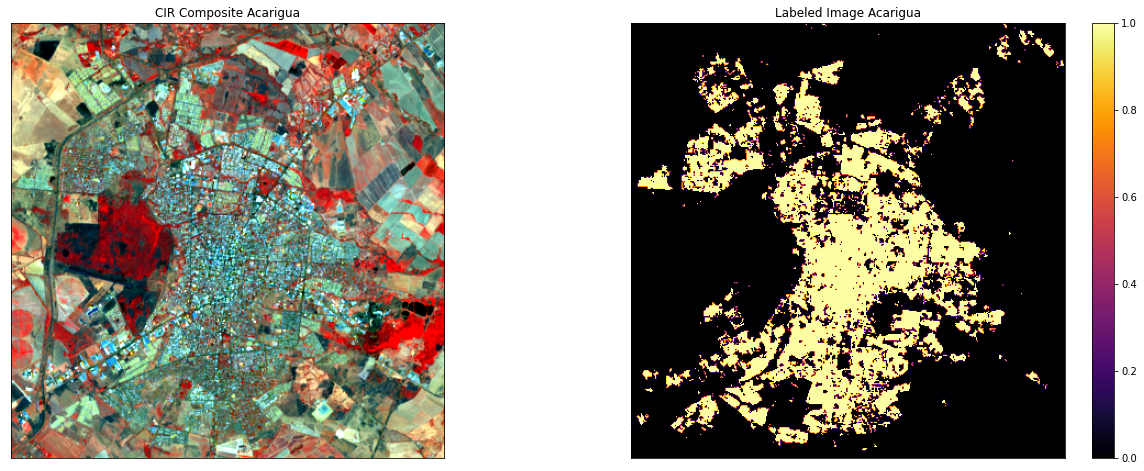

In [ ]:
vis2image(mxAcarigua, 'CIR Composite Acarigua', bB_image, 'Labeled Image Acarigua')

Through the following line of code we will extract the data from the Acarigua labeled image.

In [17]:
def bin2arr(img):
    '''
    Function to extact data from binary image
    ----------------------------------------------
    argumets:
    img: binarized image, type: numpy.array
    '''
    #  flatten the image
    flattened = img.flatten()
    # get pixel id data
    pixid = []
    [pixid.append(x) for x in range(0, flattened.shape[0])]
    #  flatten the image to list
    flattenlist = flattened.tolist()
    # convert list into a np array
    arr = np.array(flattenlist)

    return arr

In [18]:
# apply the function
bB_image = bin2arr(bB_image)
labelAcarigua = bB_image
labelAcarigua = labelAcarigua==1
print('The dimension of the array containing the Acarigua labeled data is: ', labelAcarigua.shape)

The dimension of the array containing the Acarigua labeled data is:  (156420,)


### 3.3. Cagua Data (prediction)

Next we will open the Cagua image (prediction image) with the [GDAL](https://gdal.org/) library, create an array, and generate a CIR composite.

In [19]:
mH_image = gdal.Open(mxCagua) 
mH_image = mH_image.ReadAsArray()
mH_image = np.divide(mH_image, 100)
mH_imageRGB = np.dstack((mH_image[2],mH_image[1],mH_image[0]))

# change data type
mH_imageRGB = mH_imageRGB.astype('uint8')
print('The dimension of the Cagua false color array is: ', mH_imageRGB.shape)

The dimension of the Cagua false color array is:  (241, 220, 3)


Next,  we will visualize the image of Cagua as a CIR composite. With this combination, vegetation appears in shades of red, urban areas are cyan blue, bodies of water are dark, and soils vary from dark brown to light brown [1].

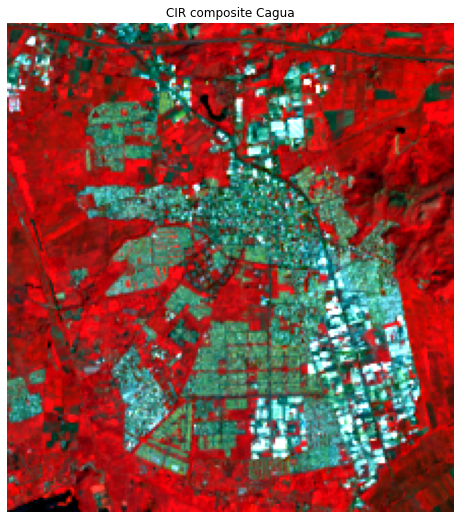

In [ ]:
vis_image(mxCagua, 'CIR composite Cagua')

Through the following line of code we will extract features of the Cagua false color array.

In [20]:
dims = mH_imageRGB.shape
cant_filas = dims[0]
cant_columnas = dims[1]
cant_pixeles = cant_filas * cant_columnas
data0= np.zeros([cant_pixeles, 4], dtype='int')
for f in range(cant_filas):
    for c in range(cant_columnas):
        nro=f*cant_columnas+c
        data0[nro,0]=nro
        data0[nro, 1:4]=mH_imageRGB[f,c,:]
        
featuresCagua = data0[:, 1:]
print('The dimension of the array containing the features of the false color of Cagua is: ', featuresCagua.shape)

The dimension of the array containing the features of the false color of Cagua is:  (53020, 3)


## 4. Neural Network Model
### 4.1. Preparing Data

Through the `train_test_split()` function we are going to obtain the data set for test and training  the NN model. Training/test ratio is 60/40.

In [21]:
Xt, Xp, yt, yp = train_test_split(featuresAcarigua, labelAcarigua, test_size=0.4, random_state=0)

print('The dimension of the dataset containing the features for training ', Xt.shape)
print('The dimension of the dataset containing the labels for training: ', yt.shape)

print('The dimension of the dataset containing the features for testing: ', Xp.shape)
print('The dimension of the dataset containing the labels for testing: ', yp.shape)

The dimension of the dataset containing the features for training  (93852, 3)
The dimension of the dataset containing the labels for training:  (93852,)
The dimension of the dataset containing the features for testing:  (62568, 3)
The dimension of the dataset containing the labels for testing:  (62568,)


Let's  normalize and reshape our training set as well as our Cagua dataset (prediction) to three dimensions so that each row represents a pixel.

---



In [22]:
# normalize data
Xt = Xt / 255.0
Xp = Xp / 255.0
featuresCagua= featuresCagua/ 255.0

# reshape data
Xt = Xt.reshape((Xt.shape[0], 1, Xt.shape[1]))
Xp = Xp.reshape((Xp.shape[0], 1, Xp.shape[1]))
featuresCagua= featuresCagua.reshape((featuresCagua.shape[0], 1, featuresCagua.shape[1]))

# print dimensions
print('Resized dataset with features for training: ', Xt.shape)
print('Resized dataset with features for testing:: ', Xp.shape)
print('Cagua resized dataset (prediction): ', featuresCagua.shape)


Resized dataset with features for training:  (93852, 1, 3)
Resized dataset with features for testing::  (62568, 1, 3)
Cagua resized dataset (prediction):  (53020, 1, 3)


### 4.2.  Building a Neural Network Model
We are going to build the Neural Networks model using [Keras](https://keras.io/). We will use the `sequential()` class which is useful when we have an input, an output, and layers stacked one after the other [2]. A Sequential model is suitable when each layer has exactly one input tensor and one output tensor [3].

In [23]:
nBands = featuresAcarigua.shape[1]
print('Number of Bands; ', nBands)

Number of Bands;  3


Our NN model will have the following structure (Figure 1):

- An input layer with a number of nodes equal to the number of bands(3).
- 12 hidden layers in 3 groups of 4 layers. The first group has  128 nodes and the `relu` activation function, the second group has 64 nodes and the `relu` activation function, and the third group has 32 nodes ans the the `relu` activation function.
- An output layer with two nodes the activation function `softmax` for built-up and non built-up classes.


In [24]:
# building Deep NN Accuracy 87%

neural_network = Sequential(name='builtup')
neural_network.add(layers.Flatten(input_shape=(1, nBands))) # input

neural_network.add(BatchNormalization(name = 'BatchNormalization'))

neural_network.add(Dense(units = 128, activation= 'relu', name = 'Layer1'))
neural_network.add(Dense(units = 128, activation= 'relu', name = 'Layer2'))
neural_network.add(Dense(units = 128, activation= 'relu', name = 'Layer3'))
neural_network.add(Dense(units = 128, activation= 'relu', name = 'Layer4'))

neural_network.add(Dropout(rate = 0.2, name = 'Dropout1',))

neural_network.add(Dense(units = 64, activation= 'relu', name = 'Layer5'))
neural_network.add(Dense(units = 64, activation= 'relu', name = 'Layer6'))
neural_network.add(Dense(units = 64, activation= 'relu', name = 'Layer7'))
neural_network.add(Dense(units = 64, activation= 'relu', name = 'Layer8'))

neural_network.add(Dropout(rate = 0.2, name = 'Dropout2'))

neural_network.add(Dense(units = 32, activation= 'relu', name = 'Layer9'))
neural_network.add(Dense(units = 32, activation= 'relu', name = 'Layer10'))
neural_network.add(Dense(units = 32, activation= 'relu', name = 'Layer11'))
neural_network.add(Dense(units = 32, activation= 'relu', name = 'Layer12'))

neural_network.add(layers.Dense(2, activation='softmax')) # output

Let's define the cost function, the optimizer and the evaluation metric using the `compile ()` method

In [25]:
neural_network.compile(loss="sparse_categorical_crossentropy", optimizer="adam",  metrics=["accuracy"])

We will use the `fit ()` method to start the training. For this execution we will define the following: 

- **Input Data**: in this case `Xt`.
- **Input data labels**: in this case `yt`
- **Number of epochs**: number of times data will pass through the neural network during the training. We arbitrarily choose 100 epochs.
- **Batch size**: amount of data that will pass through the network until a learning response is obtained through backpropagation in order to readjust the parameters. We arbitrarily choose 256 data per batch.
- **Testing Data**: in this `Xp` and `yp`.

In [26]:
#  Callbacks for Deep NN
early_stop = EarlyStopping(monitor = 'val_loss',
                   min_delta = 0,
                   patience = 15,
                   verbose = 1,
                   restore_best_weights = True)

checkpoint = ModelCheckpoint(filepath = 'builtup.h5', 
                             monitor = 'val_loss', 
                             mode ='min', 
                             save_best_only = True,
                             verbose = 1)


In [27]:
history = neural_network.fit(Xt, yt, epochs=100, batch_size = 256, validation_data = (Xp, yp), \
                             callbacks=[early_stop,checkpoint])

Epoch 1/100
367/367 [==============================] - 6s 8ms/step - loss: 0.3589 - accuracy: 0.8447 - val_loss: 0.4967 - val_accuracy: 0.7750

Epoch 00001: val_loss improved from inf to 0.49673, saving model to builtup.h5
Epoch 2/100
367/367 [==============================] - 3s 7ms/step - loss: 0.3209 - accuracy: 0.8653 - val_loss: 0.3166 - val_accuracy: 0.8630

Epoch 00002: val_loss improved from 0.49673 to 0.31661, saving model to builtup.h5
Epoch 3/100
367/367 [==============================] - 3s 8ms/step - loss: 0.3198 - accuracy: 0.8658 - val_loss: 0.3178 - val_accuracy: 0.8649

Epoch 00003: val_loss did not improve from 0.31661
Epoch 4/100
367/367 [==============================] - 3s 7ms/step - loss: 0.3183 - accuracy: 0.8662 - val_loss: 0.3103 - val_accuracy: 0.8714

Epoch 00004: val_loss improved from 0.31661 to 0.31027, saving model to builtup.h5
Epoch 5/100
367/367 [==============================] - 3s 8ms/step - loss: 0.3176 - accuracy: 0.8651 - val_loss: 0.3257 - val_ac

Let's proceed to graph the accuracy of the training and test sets

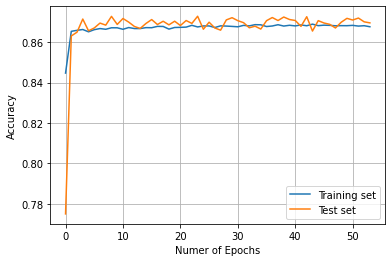

In [28]:
plt.plot(history.history['accuracy'], label = 'Training set')
plt.plot(history.history['val_accuracy'], label = 'Test set')
plt.grid()
plt.xlabel('Numer of Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show();

Let's proceed to graph the cost (error) of the training and test sets.

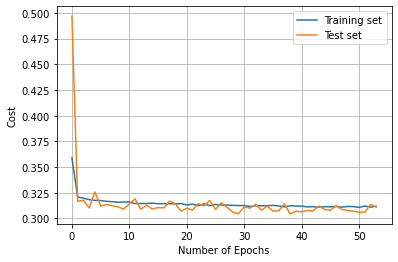

In [29]:
plt.plot(history.history['loss'], label = 'Training set')
plt.plot(history.history['val_loss'], label = 'Test set')
plt.grid()
plt.xlabel('Number of Epochs')
plt.ylabel('Cost')
plt.legend()
plt.show();

Now, we will use the `summary ()`  method to get a summary of the architecture of the network.

In [30]:
neural_network.summary()

Model: "builtup"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 3)                 0         
_________________________________________________________________
BatchNormalization (BatchNor (None, 3)                 12        
_________________________________________________________________
Layer1 (Dense)               (None, 128)               512       
_________________________________________________________________
Layer2 (Dense)               (None, 128)               16512     
_________________________________________________________________
Layer3 (Dense)               (None, 128)               16512     
_________________________________________________________________
Layer4 (Dense)               (None, 128)               16512     
_________________________________________________________________
Dropout1 (Dropout)           (None, 128)               0   

### 4.2. Prediction

Let's obtain the predictions using the `predict ()` method.

In [31]:
prediction_nn = neural_network.predict(featuresCagua)

# get prediction values
prediction_values  = prediction_nn[:,1]

After obtaining the prediction values we will create an array where **0** represents non built-up areas and **1** represents built-up areas.

In [32]:
# get rid of negative values
prediction_abs=np.sqrt(prediction_values)

# create binary values
prediction_bin = np.where(prediction_abs <= 0.316, 0, 1)

Next, we will create an array containing the prediction values.

In [33]:
prediction = np.reshape(prediction_bin, (mH_imageRGB.shape[0], mH_imageRGB.shape[1])).astype('float')

## 5. Visualization

Finally, we will visualize the Cagua CIR composite image and the predictions of built-up areas in Cagua. We can observe that yellow colors correspond to built-up areas (1), and black colors correspond to non built-up areas (0).

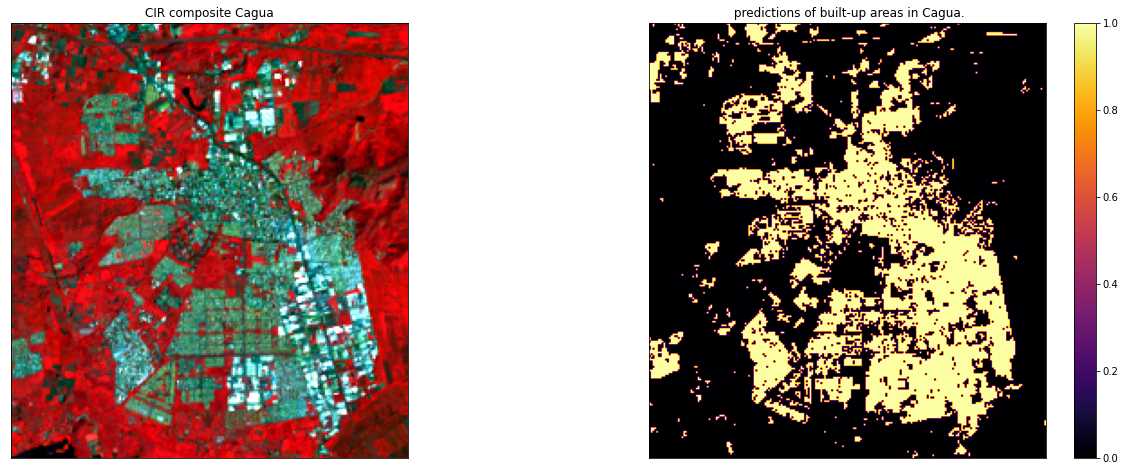

In [36]:
vis2image(mxCagua, 'CIR composite Cagua' , prediction, ' predictions of built-up areas in Cagua.')

## 6. Conclusions


*   It is possible to implement Neural Networks to predict urban growth based on built-up and remote sensing data.
*   Landsat 8 image data provide useful information to extract features for training NN models in order to predict urban growth.
* It could be interesting to investigate the influence of different image band combinations and ratios on the NN model performance.
* We suggest performing hyperparameter tuning in order to improve the general performance of the NN model (87 % accuracy).



## 7. Referrences

[1] http://web.pdx.edu/~nauna/resources/10_BandCombinations.htm. Landsat 5 Band Combinations.

[2] Francois Chollet. 2017. Deep Learning with Python (1st. ed.). Manning Publications Co., USA.

[3] https://keras.io/guides/sequential_model/. The Sequential model.